In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
from time import time
from tqdm import tqdm as tqdm
import pcmdpy_gpu as ppy
%matplotlib inline

In [2]:
mpl.style.use('seaborn-poster')

In [3]:
f = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv_cpu = ppy.driver.Driver(iso_model, gpu=False)
driv_gpu = ppy.driver.Driver(iso_model, gpu=True)

In [4]:
gals = {}
gals['ssp'] = ppy.galaxy.SSPSimple(np.array([0., -2., 2.0, 10.]), dmod=26.0)
gals['tau'] = ppy.galaxy.CustomGalaxy(
    'single',
    'single',
    'tau',
    'variable',
    initial_params=np.array([0., -2.0, 2.0, 3.0, 26.0])
)
gals['taumdf'] = ppy.galaxy.TauFull(np.array([0., -2.0, 2.0, 3.0, 26.0]))

In [5]:
%%time
imf_ssp, _ = iso_model.model_galaxy(gals['ssp'], downsample=5);

CPU times: user 12.3 ms, sys: 1.06 ms, total: 13.4 ms
Wall time: 13 ms


In [6]:
%%time
imf_tau, _ = iso_model.model_galaxy(gals['tau'], downsample=5)

CPU times: user 218 ms, sys: 19.6 ms, total: 237 ms
Wall time: 235 ms


In [7]:
%%time
imf_taumdf, _ = iso_model.model_galaxy(gals['taumdf'], downsample=5)

CPU times: user 1.48 s, sys: 3.51 ms, total: 1.48 s
Wall time: 1.48 s


In [8]:
len(imf_ssp), len(imf_tau), len(imf_taumdf)

(295, 4757, 28497)

In [9]:
N_cpu = [128, 256, 512]
N_gpu = [128, 256, 512, 1024, 2048, 4096]

In [12]:
def time_sim(gal, Nim, psf, gpu, n_sample=5, max_time_sample=10., downsample=5, **kwargs):
    times = []
    if gpu:
        driv = driv_gpu
        # get GPU warmed up
        _ = driv_gpu.simulate(gal, 128, psf=False, downsample=10)
    else:
        driv = driv_cpu
    for i in range(n_sample):
        t_start = time()
        _ = driv.simulate(gal, Nim, downsample=downsample, psf=psf, shot_noise=False, sky_noise=None, **kwargs)
        times.append(time() - t_start)
        if times[-1] > max_time_sample:
            break
    return np.median(times), times

In [13]:
def get_times(key):
    gpu_str, gal_str, psf_str = key.split('_')
    gpu = (gpu_str == 'gpu')
    if not gpu: assert gpu_str == 'nogpu'
    if gpu:
        Nims = Nims_gpu
    else:
        Nims = Nims_cpu
    psf = (psf_str == 'psf')
    if not psf: assert psf_str == 'nopsf'
    return np.array([time_sim(gals[gal_str], Nim, psf=psf, gpu=gpu)[0] for Nim in tqdm(Nims, desc=key, leave=False)])

# GPU Speedup

In [14]:
t_cpu = []
for N in tqdm(N_cpu):
    t_cpu.append(time_sim(gals['ssp'], N, psf=True, gpu=False, n_sample=10, downsample=5)[0])

100%|██████████| 3/3 [00:43<00:00, 11.98s/it]


In [15]:
t_gpu = []
for N in tqdm(N_gpu):
    t_gpu.append(time_sim(gals['ssp'], N, psf=True, gpu=True, n_sample=10, downsample=5, max_time_sample=10.)[0])

100%|██████████| 6/6 [01:56<00:00, 22.75s/it]


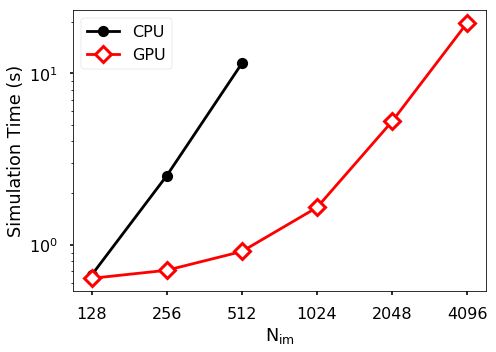

In [60]:
fig, axis = plt.subplots(figsize=(7,5))
axis.plot(N_cpu, t_cpu, 'ko-', label='CPU')
axis.plot(N_gpu, t_gpu, 'rD-', label='GPU', mfc='w', mew=3)
# axis.plot(N_cpu, t_cpu[-1] * (np.array(N_cpu) / N_cpu[-1])**2, 'k--')
# axis.plot(N_gpu, t_gpu[-1] * (np.array(N_gpu) / N_gpu[-1])**2, 'r--')
axis.set_xscale('log')
axis.set_xticks([128, 256, 512, 1024, 2048, 4096])
axis.set_xticks([], minor=True)
axis.set_xticklabels([128, 256, 512, 1024, 2048, 4096])
axis.set_yscale('log')

# axis.set_ylim(ymin=3e-1)

axis.legend(loc=0)
axis.set_xlabel(r'$\mathrm{N_{im}}$')
axis.set_ylabel('Simulation Time (s)')
plt.tight_layout()
plt.savefig('figures/paper1/gpu_speedup.pdf')

# GPU Scaling

In [17]:
imf_, mags_ = iso_model.model_galaxy(gals['taumdf'], downsample=1)

In [18]:
imf = np.tile(imf_, 10)
mags = np.tile(mags_, 10)

In [19]:
fluxes = np.array([filt.mag_to_counts(m) for filt,m in zip(f, mags)])

In [29]:
def draw(Niso, Nim=1024, gpu=True, psf=True):
    imf_temp = imf[:Niso]
    fluxes_temp = fluxes[:, :Niso]
    dust_frac, dust_mean, dust_std = gals['taumdf'].dust_model.get_props()
    images = ppy.gpu_utils.draw_image(imf_temp, fluxes_temp, Nim, f, dust_frac, dust_mean, dust_std, gpu=gpu, fixed_seed=False)
    if psf:
        images = np.array([filt.psf_convolve(im) for filt,im in zip(f, images)])
    images += 1e-3
    mags = np.array([filt.counts_to_mag(im.flatten()) for filt,im in zip(f, images)])
    pcmd = ppy.utils.make_pcmd(mags)
    return pcmd

In [34]:
def time_draw(Niso, Nim=1024, gpu=True, psf=True, n_sample=5, t_max=10.):
    times = []
    if gpu:
        # get GPU warmed up
        _ = driv_gpu.simulate(gals['ssp'], 128, psf=False, downsample=10)
    for i in range(n_sample):
        t_start = time()
        _ = draw(Niso, Nim=Nim, gpu=gpu, psf=psf)
        times.append(time() - t_start)
        if times[-1] > t_max:
            break
    return np.median(times)

In [31]:
time_draw(1000, Nim=512)

0.9718751907348633

In [33]:
Niso = [1000, 3000, 10000, 30000, 100000, 300000, 1000000]

In [35]:
t_128 = [time_draw(N, Nim=128) for N in tqdm(Niso)]

100%|██████████| 7/7 [01:25<00:00, 19.48s/it]


In [36]:
t_512 = [time_draw(N, Nim=512) for N in tqdm(Niso)]

100%|██████████| 7/7 [03:16<00:00, 41.33s/it]


In [37]:
t_1024 = [time_draw(N, Nim=1024) for N in tqdm(Niso)]

100%|██████████| 7/7 [08:46<00:00, 130.22s/it]


In [38]:
t_128

[0.6356980800628662,
 0.6508026123046875,
 0.7086505889892578,
 0.8730587959289551,
 1.4464240074157715,
 3.090702772140503,
 8.831433296203613]

In [39]:
t_512

[0.9764828681945801,
 1.1411375999450684,
 1.721299171447754,
 3.387173652648926,
 9.196478366851807,
 25.755529165267944,
 84.21068239212036]

In [40]:
t_1024

[1.9652273654937744,
 2.6107308864593506,
 4.901810884475708,
 11.459131002426147,
 34.42199754714966,
 99.82114744186401,
 329.0714294910431]

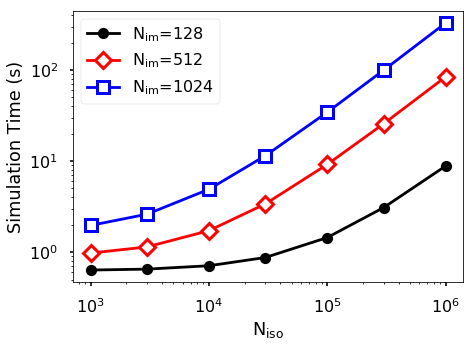

In [62]:
fig, axis = plt.subplots(figsize=(7,5))
axis.plot(Niso, t_128, 'ko-', label=r'$\mathrm{N_{im}}$=128')
axis.plot(Niso, t_512, 'rD-', label=r'$\mathrm{N_{im}}$=512', mfc='w', mew=3)
axis.plot(Niso, t_1024, 'bs-', label=r'$\mathrm{N_{im}}$=1024', mfc='w', mew=3)

axis.set_xlabel(r'$\mathrm{N_{iso}}$')
axis.set_ylabel('Simulation Time (s)')
axis.set_xscale('log')
axis.set_yscale('log')
axis.legend(loc=0)
plt.savefig('figures/paper1/gpu_scaling.pdf')